In [211]:
import numpy as np
from matplotlib import pyplot
import time

In [222]:
n = 100
theta = 3
beta = 0.95
f1, f2 = np.zeros(5, dtype = np.float64), np.zeros(5, dtype = np.float64)


In [223]:
def F(x, theta):
    return 1 - x**(1-theta)

def p(x, theta):
    return (theta-1) / x**theta

In [224]:
def randx(val, theta, step = 0.01):
    x = 1
    s = 0
    while s < val:
        s += 1/2 * (p(x, theta) + p(x + step, theta)) * step
        x += step
    return x
      
def find_gauss_broder(beta, step = 0.01):
    nado = 1/((np.pi*2)**0.5)
    sum = 0
    x = 0
    def plotnost(x):
        return nado * np.exp((-x**2) / 2)
    while sum < beta/2 :
        sum += plotnost(x) * step
        x += step
    return x, -x

In [225]:
start_time = time.time()
f = np.random.random(n)
x = [randx(g, theta) for g in f]
print(time.time() - start_time)

0.009997129440307617


# Доверительный интервал для медианы

In [226]:
e1, e2 = find_gauss_broder(beta, step = 0.001)

theta_weird = 1 + n / np.sum(np.log(x))
const = theta_weird * np.log(2) / (theta_weird - 1) / n**0.5

f1[0] = 2**(1 / (theta_weird - 1)) - e1 * const
f2[0] = 2**(1 / (theta_weird - 1)) - e2 * const 

print(f1[0], " < Xmed < ", f2[0])

1.1850096957004217  < Xmed <  1.5838256177887668


# Байесовский доверительный интервал

In [227]:
def bayes_func(x, lower_const, n, C = 1) :
    res = C / lower_const**x * np.exp(1 - x) * (x - 1)**n  
    return res

def bayer_integrate(lower, upper, lower_const, n, C = 1, step = 0.001):
    x = lower
    s = 0
    try:
        while x < upper:
            s += 1/2 * (bayes_func(x, lower_const, n, C) + bayes_func(x+step, lower_const, n, C)) * step
            x += step
    except:
        return s
    return s

def calculate_borders(beta, lower_const, n, C, step = 0.001, low = 1, up = 1000):
    c = 1/2 - beta/2
    f1, f2 = 0, 0
    
    lower = low
    upper = up
    
    s = 0
    while s < c:
        s += bayer_integrate(lower, lower + step, lower_const, n, C, step/10)
        lower += step
    f1 = lower
    
    s = 0
    while s < c:
        s += bayer_integrate(upper - step, upper, lower_const, n, C, step/10)
        upper -= step
    f2= upper
    
    return f1, f2
    



lower_const = 1
for X in x:
    lower_const *= X
C = 1 / bayer_integrate(1, 1000, lower_const, n)

f1[1], f2[1] = calculate_borders(beta, lower_const, n, C)
print(f1[1], " < \u03F4 < ", f2[1])


2.716999999999811  < ϴ <  3.5370000167346682


# Ассимптотический доверительный интервал для Тета

In [228]:
e1, e2 = find_gauss_broder(beta, step = 0.001)

theta_weird = 1 + n / np.sum(np.log(x))

f1[2] = theta_weird - e1 * (theta_weird - 1) / n**0.5
f2[2] = theta_weird - e2 * (theta_weird - 1) / n**0.5

print(f1[2], " < \u03F4 < ", f2[2])

2.713691806279522  < ϴ <  3.54816297183413


# Непараметрический Bootstrap

In [229]:
thts = []
N = 1000
for s in range (0, N):
    i = np.random.randint(0, n, n)
    xi = []
    for j in i:
        xi.append(x[j])

    thts.append(theta_weird - 1 - n / np.sum(np.log(xi)))
thts.sort()

f1[3] = thts[int((1/2 - beta/2)*N)] + theta_weird
f2[3] = thts[int((1/2 + beta/2)*N)] + theta_weird
print(f1[3], " < \u03F4 < ", f2[3])

2.5849568606694207  < ϴ <  3.5078749547562325


# Параметрический Bootstrap

In [232]:
N = 50000
theta_weird = 1 + n / np.sum(np.log(x))
thets_param = []

for i in range (0, N):
    f = np.random.random(n)
    xi = [randx(g, theta_weird) for g in f]
    theta_weird_i = 1 + n / np.sum(np.log(xi))
    thets_param.append(theta_weird - theta_weird_i)
    
thets_param.sort()
f1[4] = thets_param[int((1/2 - beta/2)*N)] + theta_weird
f2[4] = thets_param[int((1/2 + beta/2)*N)] + theta_weird
print(f1[4], " < \u03F4 < ", f2[4])

2.665182484442903  < ϴ <  3.5024564649742453


# Визуальное сравнение

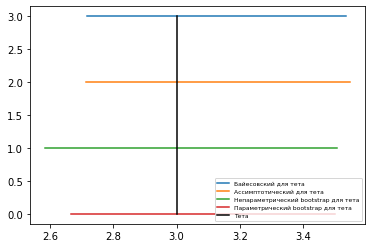

In [237]:
pyplot.plot([f1[1], f2[1]], [3, 3], label = "Байесовский для тета")
pyplot.plot([f1[2], f2[2]], [2, 2], label = "Ассимптотический для тета")
pyplot.plot([f1[3], f2[3]], [1, 1], label = "Непараметрический bootstrap для тета")
pyplot.plot([f1[4], f2[4]], [0, 0], label = "Параметрический bootstrap для тета")
pyplot.plot([theta, theta], [0, 3], color = "black", label = "Тета")

pyplot.legend(loc=4, prop={'size': 6})
pyplot.show()

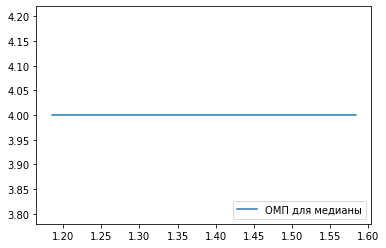

In [239]:
pyplot.plot([f1[0], f2[0]], [4, 4], label = "ОМП для медианы")
pyplot.legend(loc=4, prop={'size': 10})
pyplot.show()